### El objetivo de este proyecto es lograr crear un sistema integral que utiliza ML para determinar una clasificacion precisa que coloque a las personas en categorias de score crediticio. 
Con ello se busca:

- Automatizar la evaluacion de riesgo crediticio

- Agilizar el proceso de desicion  y el tiempo de espera de los clientes 

- Mejorar la precision de la toma de desiciones respecto a creditos y prestamos. 

Como problema de machine learning, tendremos el entrenamiento y despliegue de un modelo de clasificacion supervisada que permita realizar la clasificacion de score crediticio en tres categorias: 

- Pobre
- Standard
- Bueno

Nuestra variable objetivo es la de Credit Score, la cual posee las tres categorias antes mencionadas dentro del set de datos de entrenamiento, mientras que en set de datos de prueba tendremos solo variables predictoras que utilizaremos como un set de datos de prueba cercano a datos de la industria

In [2]:

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import inspect
import re
pd.set_option('display.max_columns', 33)
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
#Importamos las funciones que creamos y estan en el archivo mis_funciones para poder llamarlas directamente 
import mis_funciones
import importlib
importlib.reload(mis_funciones)
from mis_funciones import *

In [4]:
import os
from kaggle.api.kaggle_api_extended import KaggleApi

# Set Kaggle API credentials
os.environ['KAGGLE_USERNAME'] = 'felipekespinoza'
os.environ['KAGGLE_KEY'] = '7e80d05011f31755cc452cf4732ea604'

# Initialize the Kaggle API
api = KaggleApi()
api.authenticate()

# Download the dataset
dataset = 'parisrohan/credit-score-classification'
api.dataset_download_files(dataset, path='.', unzip=True)


Dataset URL: https://www.kaggle.com/datasets/parisrohan/credit-score-classification


In [5]:
files = os.listdir('.')
print("Archivos en el dataset:")
for file in files:
    print(file)

Archivos en el dataset:
app.py
database_credito.db
explore.ipynb
mis_funciones.py
test.csv
test.csv.zip
test.db
train.csv
utils.py
__pycache__


In [6]:
import csv
def mostrar_datos_csv(file_path, num_lines=5):
    if os.path.exists(file_path):
        with open(file_path, 'r', encoding='utf-8') as file:
            reader = csv.reader(file)
            for i, row in enumerate(reader):
                print(row)
                if i + 1 >= num_lines:
                    break
    else:
        print(f"{file_path} no encontrado")
        
        
def tipos_datos_csv(file_path, num_lines=5):
    tipos_datos = {}
    if os.path.exists(file_path):
        with open(file_path, 'r', encoding='utf-8') as file:
            reader = csv.reader(file)
            headers = next(reader)
            for header in headers:
                tipos_datos[header] = set()

            for i, row in enumerate(reader):
                for j, value in enumerate(row):
                    header = headers[j]
                    tipos_datos[header].add(type(value).__name__)
                if i + 1 >= num_lines:
                    break

        for header, types in tipos_datos.items():
            print(f"{header}: {types}")
    else:
        print(f"{file_path} no encontrado")


In [7]:
train_csv_path = os.path.join('.', 'train.csv')
test_csv_path = os.path.join('.', 'test.csv')

print("\nDatos de train.csv:")
mostrar_datos_csv(train_csv_path)

print("\nTipos de datos originales en train.csv:")
tipos_datos_csv(train_csv_path)

print("\nDatos de test.csv:")
mostrar_datos_csv(test_csv_path)

print("\nTipos de datos originales en test.csv:")
tipos_datos_csv(test_csv_path)


Datos de train.csv:
['ID', 'Customer_ID', 'Month', 'Name', 'Age', 'SSN', 'Occupation', 'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts', 'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan', 'Type_of_Loan', 'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit', 'Num_Credit_Inquiries', 'Credit_Mix', 'Outstanding_Debt', 'Credit_Utilization_Ratio', 'Credit_History_Age', 'Payment_of_Min_Amount', 'Total_EMI_per_month', 'Amount_invested_monthly', 'Payment_Behaviour', 'Monthly_Balance', 'Credit_Score']
['0x1602', 'CUS_0xd40', 'January', 'Aaron Maashoh', '23', '821-00-0265', 'Scientist', '19114.12', '1824.8433333333328', '3', '4', '3', '4', 'Auto Loan, Credit-Builder Loan, Personal Loan, and Home Equity Loan', '3', '7', '11.27', '4.0', '_', '809.98', '26.822619623699016', '22 Years and 1 Months', 'No', '49.57494921489417', '80.41529543900253', 'High_spent_Small_value_payments', '312.49408867943663', 'Good']
['0x1603', 'CUS_0xd40', 'February', 'Aaron Maashoh', '23',

In [8]:
import pandas as pd 

data_train = pd.read_csv(r'C:\Users\wipip\OneDrive\Documentos\GitHub\Proyecto-Clasificacion-de-Score-Crediticio-main\PROYECTO\src\train.csv')
data_test = pd.read_csv(r'C:\Users\wipip\OneDrive\Documentos\GitHub\Proyecto-Clasificacion-de-Score-Crediticio-main\PROYECTO\src\test.csv')

C:\Users\wipip\AppData\Local\Temp\ipykernel_9172\2209697490.py:3: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  data_train = pd.read_csv(r'C:\Users\wipip\OneDrive\Documentos\GitHub\Proyecto-Clasificacion-de-Score-Crediticio-main\PROYECTO\src\train.csv')


Guardamos los conjuntos de datos en nuestro directorio de datos no procesados

In [9]:
#data_test.to_csv(r'')

In [10]:
print(data_test.info() , data_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 27 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ID                        50000 non-null  object 
 1   Customer_ID               50000 non-null  object 
 2   Month                     50000 non-null  object 
 3   Name                      44985 non-null  object 
 4   Age                       50000 non-null  object 
 5   SSN                       50000 non-null  object 
 6   Occupation                50000 non-null  object 
 7   Annual_Income             50000 non-null  object 
 8   Monthly_Inhand_Salary     42502 non-null  float64
 9   Num_Bank_Accounts         50000 non-null  int64  
 10  Num_Credit_Card           50000 non-null  int64  
 11  Interest_Rate             50000 non-null  int64  
 12  Num_of_Loan               50000 non-null  object 
 13  Type_of_Loan              44296 non-null  object 
 14  Delay_

In [11]:
import sqlite3 

In [12]:
conn = sqlite3.connect('database_credito.db')

In [13]:
cursor = conn.cursor()

In [14]:
#data_train.to_sql('training_set', conn, if_exists='replace', index=False)
#data_test.to_sql('testing_set', conn, if_exists='replace', index=False)

In [15]:
#conn.commit()

In [16]:
query_1 = ''' 
SELECT name FROM sqlite_master WHERE type='table';

'''
cursor.execute(query_1)
tables = cursor.fetchall()

In [17]:
print("Tablas en la base de datos:")
for table in tables:
    print(table[0])

Tablas en la base de datos:
training_set
testing_set


In [18]:
#tabla_prueba = pd.read_sql_query('SELECT * FROM training_set', conn)
#tabla_prueba.head()

In [19]:
query_2 = ''' 
SELECT ID, COUNT(*)
FROM training_set
GROUP BY ID
HAVING COUNT(*) > 1;
'''
duplicados_en_training_set = pd.read_sql_query(query_2, conn )

In [20]:
print(duplicados_en_training_set.shape)

(0, 2)


Con este query podemos comprobar que no existen filas duplicadas dentro de nuestro data set de training

In [21]:
data_1 = pd.read_sql_query('SELECT * FROM training_set', conn)
data_1_test = pd.read_sql_query('SELECT * FROM testing_set', conn)


En este punto evaluamos el concatenar los data sets para realizar una limpieza y analisis de datos sin embargo se llego a la conclusion de que el data set de training posee valores suficientes para el entrenamiento, mientras que nuestro data set de testing al no poseer etiquetas no nos permite utilizarlo para evaluar el modelo, pero si nos permite tener una simualacion de un conjunto de nuevos datos que asimilen a la utilizacion del modelo en el despliegue por lo que lo tomaremos como un conjunto de prueba del cual podemos obtener conclusiones a posteriori de utilizar el modelo sobre el

In [22]:
for tabla in tables:
    print(f"\nEstructura de la tabla {tabla[0]}:")
    cursor.execute(f"PRAGMA table_info({tabla[0]});")
    columnas = cursor.fetchall()
    for columna in columnas:
        print(f"{columna[1]} - {columna[2]}")


Estructura de la tabla training_set:
ID - TEXT
Customer_ID - TEXT
Month - TEXT
Name - TEXT
Age - TEXT
SSN - TEXT
Occupation - TEXT
Annual_Income - TEXT
Monthly_Inhand_Salary - REAL
Num_Bank_Accounts - INTEGER
Num_Credit_Card - INTEGER
Interest_Rate - INTEGER
Num_of_Loan - TEXT
Type_of_Loan - TEXT
Delay_from_due_date - INTEGER
Num_of_Delayed_Payment - TEXT
Changed_Credit_Limit - TEXT
Num_Credit_Inquiries - REAL
Credit_Mix - TEXT
Outstanding_Debt - TEXT
Credit_Utilization_Ratio - REAL
Credit_History_Age - TEXT
Payment_of_Min_Amount - TEXT
Total_EMI_per_month - REAL
Amount_invested_monthly - TEXT
Payment_Behaviour - TEXT
Monthly_Balance - TEXT
Credit_Score - TEXT

Estructura de la tabla testing_set:
ID - TEXT
Customer_ID - TEXT
Month - TEXT
Name - TEXT
Age - TEXT
SSN - TEXT
Occupation - TEXT
Annual_Income - TEXT
Monthly_Inhand_Salary - REAL
Num_Bank_Accounts - INTEGER
Num_Credit_Card - INTEGER
Interest_Rate - INTEGER
Num_of_Loan - TEXT
Type_of_Loan - TEXT
Delay_from_due_date - INTEGER
Nu

In [23]:
conn.commit()

Por el momento cerramos el uso de la base de datos, una vez que analizamos la estructura de las dos tablas podemos tener una mejor idea de el tipo de datos con el que estamos trabajando, con ello podemos proceder a realizar un analisis descriptivo.

Vamos a empezar a describir el training set al cual llamamos como data_1 una vez que lo llamamos desde nuestra base de datos.

In [24]:
data_1.info()  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 28 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   ID                        100000 non-null  object 
 1   Customer_ID               100000 non-null  object 
 2   Month                     100000 non-null  object 
 3   Name                      90015 non-null   object 
 4   Age                       100000 non-null  object 
 5   SSN                       100000 non-null  object 
 6   Occupation                100000 non-null  object 
 7   Annual_Income             100000 non-null  object 
 8   Monthly_Inhand_Salary     84998 non-null   float64
 9   Num_Bank_Accounts         100000 non-null  int64  
 10  Num_Credit_Card           100000 non-null  int64  
 11  Interest_Rate             100000 non-null  int64  
 12  Num_of_Loan               100000 non-null  object 
 13  Type_of_Loan              88592 non-null   ob

Vamos a realizar un cambio de nombre en nuestras variables para que el analisi sea mas comprensible y facil de entender

In [25]:
data_1.rename(columns={
    'ID': 'ID',
    'Customer_ID': 'ID_Cliente',
    'Month': 'Mes',
    'Name': 'Nombre',
    'Age': 'Edad',
    'SSN': 'Numero_Seguridad_Social',
    'Occupation': 'Ocupacion',
    'Annual_Income': 'Ingreso_Anual',
    'Monthly_Inhand_Salary': 'Salario_Mensual_En_Mano',
    'Num_Bank_Accounts': 'Numero_Cuentas_Bancarias',
    'Num_Credit_Card': 'Numero_Tarjetas_Credito',
    'Interest_Rate': 'Tasa_Interes',
    'Num_of_Loan': 'Numero_Prestamos',
    'Type_of_Loan': 'Tipo_Prestamos',
    'Delay_from_due_date': 'Retraso_Promedio_Pagos',
    'Num_of_Delayed_Payment': 'Numero_Promedio_Pagos_Retrasados',
    'Changed_Credit_Limit': 'Cambio_Limite_Credito',
    'Num_Credit_Inquiries': 'Numero_Consultas_Credito',
    'Credit_Mix': 'Mezcla_Credito',
    'Outstanding_Debt': 'Deuda_Pendiente',
    'Credit_Utilization_Ratio': 'Ratio_Uso_Credito',
    'Credit_History_Age': 'Antiguedad_Historial_Credito',
    'Payment_of_Min_Amount': 'Pago_Monto_Minimo',
    'Total_EMI_per_month': 'Pagos_Mensuales_EMI',
    'Amount_invested_monthly': 'Monto_Mensual_Invertido',
    'Payment_Behaviour': 'Comportamiento_Pago',
    'Monthly_Balance': 'Balance_Mensual',
    'Credit_Score': 'Puntaje_Credito'
}, inplace=True)

data_1.head()


,ID,ID_Cliente,Mes,Nombre,Edad,Numero_Seguridad_Social,Ocupacion,Ingreso_Anual,Salario_Mensual_En_Mano,Numero_Cuentas_Bancarias,Numero_Tarjetas_Credito,Tasa_Interes,Numero_Prestamos,Tipo_Prestamos,Retraso_Promedio_Pagos,Numero_Promedio_Pagos_Retrasados,Cambio_Limite_Credito,Numero_Consultas_Credito,Mezcla_Credito,Deuda_Pendiente,Ratio_Uso_Credito,Antiguedad_Historial_Credito,Pago_Monto_Minimo,Pagos_Mensuales_EMI,Monto_Mensual_Invertido,Comportamiento_Pago,Balance_Mensual,Puntaje_Credito
0,0x1602,CUS_0xd40,January,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3,7,11.27,4.0,_,809.98,26.822620,22 Years and 1 Months,No,49.574949,80.41529543900253,High_spent_Small_value_payments,312.49408867943663,Good
1,0x1603,CUS_0xd40,February,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",-1,None,11.27,4.0,Good,809.98,31.944960,None,No,49.574949,118.28022162236736,Low_spent_Large_value_payments,284.62916249607184,Good
2,0x1604,CUS_0xd40,March,Aaron Maashoh,-500,821-00-0265,Scientist,19114.12,NaN,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3,7,_,4.0,Good,809.98,28.609352,22 Years and 3 Months,No,49.574949,81.699521264648,Low_spent_Medium_value_payments,331.2098628537912,Good
3,0x1605,CUS_0xd40,April,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",5,4,6.27,4.0,Good,809.98,31.377862,22 Years and 4 Months,No,49.574949,199.4580743910713,Low_spent_Small_value_payments,223.45130972736786,Good
4,0x1606,CUS_0xd40,May,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",6,None,11.27,4.0,Good,809.98,24.797347,22 Years and 5 Months,No,49.574949,41.420153086217326,High_spent_Medium_value_payments,341.48923103222177,Good


In [26]:
data_test.rename(columns={
    'ID': 'ID',
    'Customer_ID': 'ID_Cliente',
    'Month': 'Mes',
    'Name': 'Nombre',
    'Age': 'Edad',
    'SSN': 'Numero_Seguridad_Social',
    'Occupation': 'Ocupacion',
    'Annual_Income': 'Ingreso_Anual',
    'Monthly_Inhand_Salary': 'Salario_Mensual_En_Mano',
    'Num_Bank_Accounts': 'Numero_Cuentas_Bancarias',
    'Num_Credit_Card': 'Numero_Tarjetas_Credito',
    'Interest_Rate': 'Tasa_Interes',
    'Num_of_Loan': 'Numero_Prestamos',
    'Type_of_Loan': 'Tipo_Prestamos',
    'Delay_from_due_date': 'Retraso_Promedio_Pagos',
    'Num_of_Delayed_Payment': 'Numero_Promedio_Pagos_Retrasados',
    'Changed_Credit_Limit': 'Cambio_Limite_Credito',
    'Num_Credit_Inquiries': 'Numero_Consultas_Credito',
    'Credit_Mix': 'Mezcla_Credito',
    'Outstanding_Debt': 'Deuda_Pendiente',
    'Credit_Utilization_Ratio': 'Ratio_Uso_Credito',
    'Credit_History_Age': 'Antiguedad_Historial_Credito',
    'Payment_of_Min_Amount': 'Pago_Monto_Minimo',
    'Total_EMI_per_month': 'Pagos_Mensuales_EMI',
    'Amount_invested_monthly': 'Monto_Mensual_Invertido',
    'Payment_Behaviour': 'Comportamiento_Pago',
    'Monthly_Balance': 'Balance_Mensual'
}, inplace=True)

data_test.head()


,ID,ID_Cliente,Mes,Nombre,Edad,Numero_Seguridad_Social,Ocupacion,Ingreso_Anual,Salario_Mensual_En_Mano,Numero_Cuentas_Bancarias,Numero_Tarjetas_Credito,Tasa_Interes,Numero_Prestamos,Tipo_Prestamos,Retraso_Promedio_Pagos,Numero_Promedio_Pagos_Retrasados,Cambio_Limite_Credito,Numero_Consultas_Credito,Mezcla_Credito,Deuda_Pendiente,Ratio_Uso_Credito,Antiguedad_Historial_Credito,Pago_Monto_Minimo,Pagos_Mensuales_EMI,Monto_Mensual_Invertido,Comportamiento_Pago,Balance_Mensual
0,0x160a,CUS_0xd40,September,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3,7,11.27,2022.0,Good,809.98,35.030402,22 Years and 9 Months,No,49.574949,236.64268203272135,Low_spent_Small_value_payments,186.26670208571772
1,0x160b,CUS_0xd40,October,Aaron Maashoh,24,821-00-0265,Scientist,19114.12,1824.843333,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3,9,13.27,4.0,Good,809.98,33.053114,22 Years and 10 Months,No,49.574949,21.465380264657146,High_spent_Medium_value_payments,361.44400385378196
2,0x160c,CUS_0xd40,November,Aaron Maashoh,24,821-00-0265,Scientist,19114.12,1824.843333,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",-1,4,12.27,4.0,Good,809.98,33.811894,NaN,No,49.574949,148.23393788500925,Low_spent_Medium_value_payments,264.67544623342997
3,0x160d,CUS_0xd40,December,Aaron Maashoh,24_,821-00-0265,Scientist,19114.12,NaN,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",4,5,11.27,4.0,Good,809.98,32.430559,23 Years and 0 Months,No,49.574949,39.08251089460281,High_spent_Medium_value_payments,343.82687322383634
4,0x1616,CUS_0x21b1,September,Rick Rothackerj,28,004-07-5839,_______,34847.84,3037.986667,2,4,6,1,Credit-Builder Loan,3,1,5.42,5.0,Good,605.03,25.926822,27 Years and 3 Months,No,18.816215,39.684018417945296,High_spent_Large_value_payments,485.2984336755923


Una vez que hacemos esto podemos empezar a descartar variables que son redundantemente poco utiles para nuestras predicciones 

In [27]:
#haremos un chequeo de duplicados con id, costumer id y nombre de forma rapida

duplicated_rows = data_1.duplicated(subset=['ID', 'ID_Cliente', 'Nombre'])
print("Filas duplicadas basadas en 'ID', 'ID_Cliente', 'Nombre':")
print(data_1[duplicated_rows])



Filas duplicadas basadas en 'ID', 'ID_Cliente', 'Nombre':
Empty DataFrame
Columns: [ID, ID_Cliente, Mes, Nombre, Edad, Numero_Seguridad_Social, Ocupacion, Ingreso_Anual, Salario_Mensual_En_Mano, Numero_Cuentas_Bancarias, Numero_Tarjetas_Credito, Tasa_Interes, Numero_Prestamos, Tipo_Prestamos, Retraso_Promedio_Pagos, Numero_Promedio_Pagos_Retrasados, Cambio_Limite_Credito, Numero_Consultas_Credito, Mezcla_Credito, Deuda_Pendiente, Ratio_Uso_Credito, Antiguedad_Historial_Credito, Pago_Monto_Minimo, Pagos_Mensuales_EMI, Monto_Mensual_Invertido, Comportamiento_Pago, Balance_Mensual, Puntaje_Credito]
Index: []


Confirmamos no tener filas duplicadas

In [28]:
data_1.columns  


Index(['ID', 'ID_Cliente', 'Mes', 'Nombre', 'Edad', 'Numero_Seguridad_Social',
       'Ocupacion', 'Ingreso_Anual', 'Salario_Mensual_En_Mano',
       'Numero_Cuentas_Bancarias', 'Numero_Tarjetas_Credito', 'Tasa_Interes',
       'Numero_Prestamos', 'Tipo_Prestamos', 'Retraso_Promedio_Pagos',
       'Numero_Promedio_Pagos_Retrasados', 'Cambio_Limite_Credito',
       'Numero_Consultas_Credito', 'Mezcla_Credito', 'Deuda_Pendiente',
       'Ratio_Uso_Credito', 'Antiguedad_Historial_Credito',
       'Pago_Monto_Minimo', 'Pagos_Mensuales_EMI', 'Monto_Mensual_Invertido',
       'Comportamiento_Pago', 'Balance_Mensual', 'Puntaje_Credito'],
      dtype='object')

En este caso podemos ver en la lista variables como id, id de cliente, mes, nombre y numero de seguro social, que son variables de identificacion que no tienen valor para el modelo que vamos a crear, por lo que las vamos a descartar para agilizar el proceso de analisis.

In [29]:
data_2 = data_1[[
    #'ID', 
    #'ID_Cliente', 
    #'Mes', 
    #'Nombre', 
    'Edad', 
    #'Numero_Seguridad_Social',
    'Ocupacion',
    'Ingreso_Anual', 
    'Salario_Mensual_En_Mano',
    'Numero_Cuentas_Bancarias', 
    'Numero_Tarjetas_Credito',
    'Tasa_Interes',
    'Numero_Prestamos',
    'Tipo_Prestamos',
    'Retraso_Promedio_Pagos',
    'Numero_Promedio_Pagos_Retrasados',
    'Cambio_Limite_Credito',
    'Numero_Consultas_Credito',
    'Mezcla_Credito',
    'Deuda_Pendiente',
    'Ratio_Uso_Credito',
    'Antiguedad_Historial_Credito',
    'Pago_Monto_Minimo', 
    'Pagos_Mensuales_EMI', 
    'Monto_Mensual_Invertido',
    'Comportamiento_Pago',
    'Balance_Mensual',
    'Puntaje_Credito']].copy()

In [30]:
data_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 23 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   Edad                              100000 non-null  object 
 1   Ocupacion                         100000 non-null  object 
 2   Ingreso_Anual                     100000 non-null  object 
 3   Salario_Mensual_En_Mano           84998 non-null   float64
 4   Numero_Cuentas_Bancarias          100000 non-null  int64  
 5   Numero_Tarjetas_Credito           100000 non-null  int64  
 6   Tasa_Interes                      100000 non-null  int64  
 7   Numero_Prestamos                  100000 non-null  object 
 8   Tipo_Prestamos                    88592 non-null   object 
 9   Retraso_Promedio_Pagos            100000 non-null  int64  
 10  Numero_Promedio_Pagos_Retrasados  92998 non-null   object 
 11  Cambio_Limite_Credito             100000 non-null  ob

Para iniciar con el analisis descriptivo podemos identificar valores faltantes o nulos dentro de 9 columnas en el data set, se deberan imputar o eliminar mas adelante dependiendo de lo que sea mejor para el analisis, aniadiendo a esto tambien tendremos que tomar en cuenta si tenemos datos atipicos que debamos imputar.

El data set incialmente tiene 27 caracteristicas y 100,000 instancias.

Tenemos una gran cantidad de caracteristicas que son identificadas como objetos por pandas, por lo que mas adelante haremos una analisis a detalle sobre si debemos darle un formato especifico al tipo de dato  para poder trabajar con el a medida que avance el analisis.

In [31]:
data_2.describe()

,Salario_Mensual_En_Mano,Numero_Cuentas_Bancarias,Numero_Tarjetas_Credito,Tasa_Interes,Retraso_Promedio_Pagos,Numero_Consultas_Credito,Ratio_Uso_Credito,Pagos_Mensuales_EMI
count,84998.000000,100000.000000,100000.00000,100000.000000,100000.000000,98035.000000,100000.000000,100000.000000
mean,4194.170850,17.091280,22.47443,72.466040,21.068780,27.754251,32.285173,1403.118217
std,3183.686167,117.404834,129.05741,466.422621,14.860104,193.177339,5.116875,8306.041270
min,303.645417,-1.000000,0.00000,1.000000,-5.000000,0.000000,20.000000,0.000000
25%,1625.568229,3.000000,4.00000,8.000000,10.000000,3.000000,28.052567,30.306660
50%,3093.745000,6.000000,5.00000,13.000000,18.000000,6.000000,32.305784,69.249473
75%,5957.448333,7.000000,7.00000,20.000000,28.000000,9.000000,36.496663,161.224249
max,15204.633333,1798.000000,1499.00000,5797.000000,67.000000,2597.000000,50.000000,82331.000000


Vamos a iniciar describiendo nuestras variables numericas

Salario mensual a la mano: (contiene valores nulos: aprox 16 mil)

Es una variable que parece indicar el salario que se tiene como dinero liquido de forma mensual. Podemos ver una media salarial de 4,194 dolares (asumimos la moneda debido a que el data set es de estados unidos), tenemos una variacion estandar de 3,183 por lo que es importante denotar que hay una dispersion relativamente significante. tenemos un primer cuartil de 1,625 por lo que sabeos que el 25% de los salarios son mas bajos que este numero. La mediana es de 3,093, esto significa que el 50% de las personas tienen un salario menor a este numero. el tercer cuartil nos dice que el 75% de las personas estaran con un salario mensual disponible menor a 5,975. Finalmente tendremos un minimo de salario de 303 dolares y un maximo de 15,204. Con un minimo diferente a cero sabremos que en esta columna no es necesario imputar valores de cero.

#### Es importante diferenciar las deducciones de la deuda, ya que las deducciones se refieren a impuestos principalmente, sabemos que esta es la cantidad de dinero que la persona recibe en su cuenta mensualmente, es una de las principales caracteristicas ya que a mayor salario es mayor la capacidad de pagar las deudas y viceversa.

numero de cuentas de banco que posee el cliente: (sin valores nulos)

media de 17, variacion estandar de 17, primer cuartil de 3, mediana de 6 y tercer cuartil de 7, con un maximo de 1798 y un minimo de menos uno.( * * * * Investigar el numero de cuentas comun en USA) 

#### Los maximos y minimos nos indican que tenemos datos atipicos ya que no tiene sentido tener menos 1 de numero de cuentas o de 1798 por lo que se debe limpiar esto.

Cantidad de tarjetas de credito que tiene una persona: (0 valores nulos):
Estadisticamente tendremos una media de 22, una desviacion estandar de 129, tendremos un minimo de 0, maximo de 1499, 25% por debajo de 4, 50% por debajo de 5 y 75% por debajo de 7.
#### El maximo indica outilers, a la vez se debe tener cuidado para identificar el numero de tarjertas de credito que pondremos como limite normal debido a que un numero alto puede ser un indicador de riesgo para el score crediticio. 


Tasa de interes de las tarjetas de credito: (sin valores nulos)

Tenemos un rango de 1 a 5797% (indicacion de outliers).
media de 72.5% y desviacion de 466%.
25% por debajo de 8%, mediana de 13% y 75% por debajo de 20%.
#### Con nuestros cuantiles podemos estar seguros de que es necesario hacer un analisis de outlier y tratar estos datos para determinar las tasas de interes validas, debido a que es comun que las tasas de interes esten normalizadas en el mercado, tambien deben ser verificadas por instituciones financieras, por lo que es muy posible que los valores por encima cierto rango sean errores.

Dias de retraso desde la fecha de vencimiento de pago:
Rango de -5 a 67 dias (el minimo indica valores que debemos revisar)
media de 21.1 dias
desviacion estandar de 14.9 dias
vemos una mediana de 18, 25% por debajo de 10 y 75% por debajo de 28.
#### Los valores negativos en este caso podrian indicar que se tiene un pago anticipado, sin embargo esto puede ser problematico para el modelo ya que el retraso en el pago es caracteristico de la generacion de intereses extra lo cual a su vez es un indicador de una conducta financiera riesgosa cosa que es importante para determinar un score crediticio por lo que se evaluara si es necesario normalizar los datos negativos a cero para mantener la estructura para el modelo.


Numero de consultas de credito:
media de 27.8, desviacion estandar de 193.
cuantiles de 25% por debajo de 3, 50% por debajo de 6, 75% por debajo de 9, minetras que el rango es de 0 a 2597.
#### Un numero alto de consultas se asocia con un comportamiento riesgoso, por lo que se deben limpiar los outliers, a la vez tenemos que averiguar si es posible consultar o crear un indicador de que tan recientes son las consultas ya que un numero alto de consultas recientes es aun mayor indicador de riesgo.

Radio de utilizacion de credito: (sin valores nulos):
Media del 32.3%
std 5.12%
cuantiles: 25%: 28.1, 50%: 32.3, 75%: 36.5 
minimo de 20% y maximo de 50%. 
#### El radio de utilizacion de credito nos dice el porcentaje de credito se esta utilizando acorde al total de credito que se tiene disponible, es buena practica que este radio sea menor al 30% por lo que entre mas alto es el numero es un mayor indicador de riesgo para la institucion. Mantener un radio menor sera indicador de un mejor score crediticio. 

Cuota mensual equivalente: (sin valores nulos) 
Es la cantidad total de dinero que una persona paga por prestamos o creditos mensualmente, suma de hipoteca, carro, pp, etc. 
#### esto se debe comparar con el ingreso mensual para determinar que cantidad de ese ingreso se va a pagos mensuales.
media de 1,403, std de 8,306
25% bajo 30, 50% bajo 69, 75% bajo 161
rango de 0 a 82,331 (el maximo puede ser un outlier pero esto no es del todo correcto ya que puede representar un caso verdadero y coherente de deuda)

#### Un EMI alto es un indicador de sobrecarga financiera por lo que sera importante para nuestro modelo. Se debe tomar en cuenta que comparado con el salario de ingreso tendremos la capacidad de una persona de pagar sus deudas actuales.
### Crearemos una columna que combine salario con deuda mensuales para determinar un porcentaje del salario disponible que se va a el pago de la deuda, si tenemos un radio alto de deuda / ingreso sera un indicador de alto riesgo de incumplimiento ya que demuestra una incapacidad de pagar nuevos creditos.











Continuamos con el analisis descriptivo de las variables categoricas, con este se pretende entender la frecuencia absoluta y relativa de cada una y determinar de forma inicial como podrian tomar partido en el desempenio de nuestro modelo

Como variables categoricas tenemos: 
- Ocupacion 
- tipo de prestamo 
- mezcla de credito 
- Solo pago el monto minimo 
- comportamiento de pago 
- score crediticio


In [32]:
#Primero vemos una lista de las variables categoricas 
varibles_categoricas = [
    'Ocupacion', 
    'Tipo_Prestamos', 
    'Mezcla_Credito',
    'Pago_Monto_Minimo', 
    'Comportamiento_Pago', 
    'Puntaje_Credito'
]

In [33]:
funciones = [func[0] for func in inspect.getmembers(mis_funciones, inspect.isfunction)]

print("Funciones definidas en 'mi_lista_de_funciones.py':")
for funcion in funciones:
    print(funcion)

Funciones definidas en 'mi_lista_de_funciones.py':
analisis_grafico_variables_numericas
calculo_frecuencia_var_categoricas
mostrar_frecuencia_categoricas


Llamaremos una de nuestras funciones para ver frecuencia absoluta y relativa de cada variable 

In [34]:
calculo_frecuencia_var_categoricas(data_2)

{'Edad':      Variable Categoría  Frecuencia Absoluta  Frecuencia Relativa
 0        Edad        38                 2833              0.02833
 1        Edad        28                 2829              0.02829
 2        Edad        31                 2806              0.02806
 3        Edad        26                 2792              0.02792
 4        Edad        32                 2749              0.02749
 ...       ...       ...                  ...                  ...
 1783     Edad       471                    1              0.00001
 1784     Edad      1520                    1              0.00001
 1785     Edad      8663                    1              0.00001
 1786     Edad      3363                    1              0.00001
 1787     Edad      1342                    1              0.00001
 
 [1788 rows x 4 columns],
 'Ocupacion':      Variable      Categoría  Frecuencia Absoluta  Frecuencia Relativa
 0   Ocupacion        _______                 7062              0.07062
 1 

Mostramos el resumen de todas las caracteristicas categoricas llamando la funcion y utillizando un ciclo for para ver cada una

In [35]:
valores_unicos = data_2['Edad'].unique().tolist()
print(valores_unicos)

['23', '-500', '28_', '28', '34', '54', '55', '21', '31', '33', '34_', '7580', '30', '30_', '24', '24_', '44', '45', '40', '41', '32', '33_', '35', '35_', '36', '39', '37', '181', '20', '46', '26', '42', '19', '31_', '48', '995', '40_', '37_', '38', '54_', '5079', '43', '21_', '22', '6409', '16', '7080', '18', '849', '3885', '20_', '15', '27', '43_', '38_', '25', '3052', '14', '5342', '17', '18_', '4431', '2657', '2111_', '46_', '47', '1032', '16_', '19_', '47_', '456', '5717', '53_', '53', '56', '25_', '27_', '55_', '3169', '1191', '29', '42_', '7140', '48_', '49', '49_', '8233', '6955', '2534', '3115', '7657', '51', '50', '5112', '50_', '32_', '6452', '2744', '22_', '17_', '1439', '29_', '5795', '4872', '1772', '15_', '1383', '5657', '52', '1934', '51_', '8352', '3734', '26_', '2056', '39_', '7508', '2339', '14_', '8406', '1424', '36_', '6953', '5626', '4471', '548', '44_', '769', '5490', '525', '4202', '3665', '7670_', '4670', '3616', '6922', '6619', '1808', '7992', '45_', '223', '1

In [36]:
mostrar_frecuencia_categoricas(data_2)

Tablero de frecuencias de la característica: Edad


,Variable,Categoría,Frecuencia Absoluta,Frecuencia Relativa
0,Edad,38,2833,0.02833
1,Edad,28,2829,0.02829
2,Edad,31,2806,0.02806
3,Edad,26,2792,0.02792
4,Edad,32,2749,0.02749
...,...,...,...,...
1783,Edad,471,1,0.00001
1784,Edad,1520,1,0.00001
1785,Edad,8663,1,0.00001
1786,Edad,3363,1,0.00001


Tablero de frecuencias de la característica: Ocupacion


,Variable,Categoría,Frecuencia Absoluta,Frecuencia Relativa
0,Ocupacion,_______,7062,0.07062
1,Ocupacion,Lawyer,6575,0.06575
2,Ocupacion,Architect,6355,0.06355
3,Ocupacion,Engineer,6350,0.06350
4,Ocupacion,Scientist,6299,0.06299
5,Ocupacion,Mechanic,6291,0.06291
6,Ocupacion,Accountant,6271,0.06271
7,Ocupacion,Developer,6235,0.06235
8,Ocupacion,Media_Manager,6232,0.06232
9,Ocupacion,Teacher,6215,0.06215


Tablero de frecuencias de la característica: Ingreso_Anual


,Variable,Categoría,Frecuencia Absoluta,Frecuencia Relativa
0,Ingreso_Anual,36585.12,16,0.00016
1,Ingreso_Anual,20867.67,16,0.00016
2,Ingreso_Anual,17273.83,16,0.00016
3,Ingreso_Anual,9141.63,15,0.00015
4,Ingreso_Anual,33029.66,15,0.00015
...,...,...,...,...
18935,Ingreso_Anual,20269.93_,1,0.00001
18936,Ingreso_Anual,15157.25_,1,0.00001
18937,Ingreso_Anual,44955.64_,1,0.00001
18938,Ingreso_Anual,76650.12_,1,0.00001


Tablero de frecuencias de la característica: Numero_Prestamos


,Variable,Categoría,Frecuencia Absoluta,Frecuencia Relativa
0,Numero_Prestamos,3,14386,0.14386
1,Numero_Prestamos,2,14250,0.14250
2,Numero_Prestamos,4,14016,0.14016
3,Numero_Prestamos,0,10380,0.10380
4,Numero_Prestamos,1,10083,0.10083
...,...,...,...,...
429,Numero_Prestamos,1320_,1,0.00001
430,Numero_Prestamos,103,1,0.00001
431,Numero_Prestamos,1444,1,0.00001
432,Numero_Prestamos,392,1,0.00001


Tablero de frecuencias de la característica: Tipo_Prestamos


,Variable,Categoría,Frecuencia Absoluta,Frecuencia Relativa
0,Tipo_Prestamos,Not Specified,1408,0.015893
1,Tipo_Prestamos,Credit-Builder Loan,1280,0.014448
2,Tipo_Prestamos,Personal Loan,1272,0.014358
3,Tipo_Prestamos,Debt Consolidation Loan,1264,0.014268
4,Tipo_Prestamos,Student Loan,1240,0.013997
...,...,...,...,...
6255,Tipo_Prestamos,"Not Specified, Mortgage Loan, Auto Loan, and P...",8,0.000090
6256,Tipo_Prestamos,"Payday Loan, Mortgage Loan, Debt Consolidation...",8,0.000090
6257,Tipo_Prestamos,"Debt Consolidation Loan, Auto Loan, Personal L...",8,0.000090
6258,Tipo_Prestamos,"Student Loan, Auto Loan, Student Loan, Credit-...",8,0.000090


Tablero de frecuencias de la característica: Numero_Promedio_Pagos_Retrasados


,Variable,Categoría,Frecuencia Absoluta,Frecuencia Relativa
0,Numero_Promedio_Pagos_Retrasados,19,5327,0.057281
1,Numero_Promedio_Pagos_Retrasados,17,5261,0.056571
2,Numero_Promedio_Pagos_Retrasados,16,5173,0.055625
3,Numero_Promedio_Pagos_Retrasados,10,5153,0.055410
4,Numero_Promedio_Pagos_Retrasados,18,5083,0.054657
...,...,...,...,...
744,Numero_Promedio_Pagos_Retrasados,848_,1,0.000011
745,Numero_Promedio_Pagos_Retrasados,4134,1,0.000011
746,Numero_Promedio_Pagos_Retrasados,1530,1,0.000011
747,Numero_Promedio_Pagos_Retrasados,1502,1,0.000011


Tablero de frecuencias de la característica: Cambio_Limite_Credito


,Variable,Categoría,Frecuencia Absoluta,Frecuencia Relativa
0,Cambio_Limite_Credito,_,2091,0.02091
1,Cambio_Limite_Credito,8.22,133,0.00133
2,Cambio_Limite_Credito,11.5,127,0.00127
3,Cambio_Limite_Credito,11.32,126,0.00126
4,Cambio_Limite_Credito,7.35,121,0.00121
...,...,...,...,...
4379,Cambio_Limite_Credito,-1.84,1,0.00001
4380,Cambio_Limite_Credito,0.8899999999999999,1,0.00001
4381,Cambio_Limite_Credito,28.06,1,0.00001
4382,Cambio_Limite_Credito,1.5599999999999996,1,0.00001


Tablero de frecuencias de la característica: Mezcla_Credito


,Variable,Categoría,Frecuencia Absoluta,Frecuencia Relativa
0,Mezcla_Credito,Standard,36479,0.36479
1,Mezcla_Credito,Good,24337,0.24337
2,Mezcla_Credito,_,20195,0.20195
3,Mezcla_Credito,Bad,18989,0.18989


Tablero de frecuencias de la característica: Deuda_Pendiente


,Variable,Categoría,Frecuencia Absoluta,Frecuencia Relativa
0,Deuda_Pendiente,1360.45,24,0.00024
1,Deuda_Pendiente,460.46,23,0.00023
2,Deuda_Pendiente,1151.7,23,0.00023
3,Deuda_Pendiente,1109.03,23,0.00023
4,Deuda_Pendiente,467.7,16,0.00016
...,...,...,...,...
13173,Deuda_Pendiente,245.46_,1,0.00001
13174,Deuda_Pendiente,645.77_,1,0.00001
13175,Deuda_Pendiente,174.79_,1,0.00001
13176,Deuda_Pendiente,1181.13_,1,0.00001


Tablero de frecuencias de la característica: Antiguedad_Historial_Credito


,Variable,Categoría,Frecuencia Absoluta,Frecuencia Relativa
0,Antiguedad_Historial_Credito,15 Years and 11 Months,446,0.004903
1,Antiguedad_Historial_Credito,19 Years and 4 Months,445,0.004892
2,Antiguedad_Historial_Credito,19 Years and 5 Months,444,0.004881
3,Antiguedad_Historial_Credito,17 Years and 11 Months,443,0.004870
4,Antiguedad_Historial_Credito,19 Years and 3 Months,441,0.004848
...,...,...,...,...
399,Antiguedad_Historial_Credito,0 Years and 3 Months,20,0.000220
400,Antiguedad_Historial_Credito,0 Years and 2 Months,15,0.000165
401,Antiguedad_Historial_Credito,33 Years and 7 Months,14,0.000154
402,Antiguedad_Historial_Credito,33 Years and 8 Months,12,0.000132


Tablero de frecuencias de la característica: Pago_Monto_Minimo


,Variable,Categoría,Frecuencia Absoluta,Frecuencia Relativa
0,Pago_Monto_Minimo,Yes,52326,0.52326
1,Pago_Monto_Minimo,No,35667,0.35667
2,Pago_Monto_Minimo,NM,12007,0.12007


Tablero de frecuencias de la característica: Monto_Mensual_Invertido


,Variable,Categoría,Frecuencia Absoluta,Frecuencia Relativa
0,Monto_Mensual_Invertido,__10000__,4305,0.045069
1,Monto_Mensual_Invertido,0.0,169,0.001769
2,Monto_Mensual_Invertido,80.41529543900253,1,0.000010
3,Monto_Mensual_Invertido,36.66235139442514,1,0.000010
4,Monto_Mensual_Invertido,89.7384893604547,1,0.000010
...,...,...,...,...
91044,Monto_Mensual_Invertido,36.541908593249026,1,0.000010
91045,Monto_Mensual_Invertido,93.45116318631192,1,0.000010
91046,Monto_Mensual_Invertido,140.80972223052834,1,0.000010
91047,Monto_Mensual_Invertido,38.73937670100975,1,0.000010


Tablero de frecuencias de la característica: Comportamiento_Pago


,Variable,Categoría,Frecuencia Absoluta,Frecuencia Relativa
0,Comportamiento_Pago,Low_spent_Small_value_payments,25513,0.25513
1,Comportamiento_Pago,High_spent_Medium_value_payments,17540,0.17540
2,Comportamiento_Pago,Low_spent_Medium_value_payments,13861,0.13861
3,Comportamiento_Pago,High_spent_Large_value_payments,13721,0.13721
4,Comportamiento_Pago,High_spent_Small_value_payments,11340,0.11340
5,Comportamiento_Pago,Low_spent_Large_value_payments,10425,0.10425
6,Comportamiento_Pago,!@9#%8,7600,0.07600


Tablero de frecuencias de la característica: Balance_Mensual


,Variable,Categoría,Frecuencia Absoluta,Frecuencia Relativa
0,Balance_Mensual,__-333333333333333333333333333__,9,0.000091
1,Balance_Mensual,312.49408867943663,1,0.000010
2,Balance_Mensual,415.32532309844316,1,0.000010
3,Balance_Mensual,252.08489793906085,1,0.000010
4,Balance_Mensual,254.9709216273975,1,0.000010
...,...,...,...,...
98787,Balance_Mensual,366.2890379762706,1,0.000010
98788,Balance_Mensual,151.1882696261166,1,0.000010
98789,Balance_Mensual,306.75027851710234,1,0.000010
98790,Balance_Mensual,278.8720257394474,1,0.000010


Tablero de frecuencias de la característica: Puntaje_Credito


,Variable,Categoría,Frecuencia Absoluta,Frecuencia Relativa
0,Puntaje_Credito,Standard,53174,0.53174
1,Puntaje_Credito,Poor,28998,0.28998
2,Puntaje_Credito,Good,17828,0.17828


{'Edad':      Variable Categoría  Frecuencia Absoluta  Frecuencia Relativa
 0        Edad        38                 2833              0.02833
 1        Edad        28                 2829              0.02829
 2        Edad        31                 2806              0.02806
 3        Edad        26                 2792              0.02792
 4        Edad        32                 2749              0.02749
 ...       ...       ...                  ...                  ...
 1783     Edad       471                    1              0.00001
 1784     Edad      1520                    1              0.00001
 1785     Edad      8663                    1              0.00001
 1786     Edad      3363                    1              0.00001
 1787     Edad      1342                    1              0.00001
 
 [1788 rows x 4 columns],
 'Ocupacion':      Variable      Categoría  Frecuencia Absoluta  Frecuencia Relativa
 0   Ocupacion        _______                 7062              0.07062
 1 

### Notas Guardadas (Invertidas y Numeradas):

1. **C:1** NM en Pago_Monto_Minimo probablemente significa "No Mencionado" o "No Disponible"
2. **C:2** edad tiene valores atípico de conteo igual a uno y sin sentido y es numerica ---------------------
3. **C:3** numero de prestamos presenta el mismo problema que edad, es numerica ------------------------------
4. **C:4** tipo de prestamos tiene muchas categorías, podemos reducirlo haciendo clasificación con un modelo de aprendizaje no supervisado
5. **C:5** se puede hacer lo mismo con ingreso anual para dejarla categórica y que tenga menos categorías, numerica --------------
6. **C:6** numero promedio de pagos retrasados puede tener el mismo problema que edad, pero en este caso considero que si puede volverse numerica y podemos eliminar los outliers o reemplazarlos con ceros, numerica ------------------------------------
7. **C:7** cambio limite de credito es una variable numerica por completo, no hay nada que discutir unicamente debemos convertirla a numerica--------------------------------
8. **C:8** en mezcla _credito cambiar la categoría de -- por un NO
9. **C:9** deuda pendiente es una variable numerica------------------------------------
10. **C:10** antiguedad de historial de credito puede convertirse en numerica utilizando solo un tipo de tensor
11. **C:11** pago_monto_minimo, actualizar nombre a solo pago monto minimo, también, tenemos NM que es no mencionado, recomiendo dejarla así
12. **C:12** monto mensual invertido, es una variable numerica no categorica --------------------------------------------------
13. **C:13** comportamiento de pago tiene un valor de categoría que no tiene sentido, el cual debemos cambiar a desconocido
14. **C:14** balance mensual es una variable numerica ---------------------------------------   




Cambio a numericas:
    'Edad',
    'Ingreso_Anual',
    'Numero_Prestamos',
    'Numero_Promedio_Pagos_Retrasados',
    'Cambio_Limite_Credito',
    'Deuda_Pendiente',
    'Antiguedad_Historial_Credito',
    'Monto_Mensual_Invertido',
    'Balance_Mensual'

In [37]:
data_3 = data_2.copy()
print('Tipos de dato iniciales')
print(data_3.dtypes)

Tipos de dato iniciales
Edad                                 object
Ocupacion                            object
Ingreso_Anual                        object
Salario_Mensual_En_Mano             float64
Numero_Cuentas_Bancarias              int64
Numero_Tarjetas_Credito               int64
Tasa_Interes                          int64
Numero_Prestamos                     object
Tipo_Prestamos                       object
Retraso_Promedio_Pagos                int64
Numero_Promedio_Pagos_Retrasados     object
Cambio_Limite_Credito                object
Numero_Consultas_Credito            float64
Mezcla_Credito                       object
Deuda_Pendiente                      object
Ratio_Uso_Credito                   float64
Antiguedad_Historial_Credito         object
Pago_Monto_Minimo                    object
Pagos_Mensuales_EMI                 float64
Monto_Mensual_Invertido              object
Comportamiento_Pago                  object
Balance_Mensual                      object
Puntaje_

In [38]:
varibles_a_cambiar =[
    'Edad',
    'Ingreso_Anual',
    'Numero_Prestamos',
    'Numero_Promedio_Pagos_Retrasados',
    'Cambio_Limite_Credito',
    'Deuda_Pendiente',
    'Monto_Mensual_Invertido',
    'Balance_Mensual'
]



Estas son las variables que tenemos que cambiar de formato de objeto a un tipo de dato numerico para poder continuar correctamente con el analisis. (Es importante mencionar que la variable de antiguedad de historial crediticio debe cambiarse por otro metodo)

In [39]:
data_3[varibles_a_cambiar].head()

,Edad,Ingreso_Anual,Numero_Prestamos,Numero_Promedio_Pagos_Retrasados,Cambio_Limite_Credito,Deuda_Pendiente,Monto_Mensual_Invertido,Balance_Mensual
0,23,19114.12,4,7,11.27,809.98,80.41529543900253,312.49408867943663
1,23,19114.12,4,None,11.27,809.98,118.28022162236736,284.62916249607184
2,-500,19114.12,4,7,_,809.98,81.699521264648,331.2098628537912
3,23,19114.12,4,4,6.27,809.98,199.4580743910713,223.45130972736786
4,23,19114.12,4,None,11.27,809.98,41.420153086217326,341.48923103222177


Utilizaremos un par de funciones para limpiar las entradas de caracteres que pueden provocar que nuestros valores sean nulos y los cambiaremos al formato numerico 

In [40]:
def limpiar_y_convertir_a_numerico(valor):
    valor_limpio = re.sub(r'[^0-9.-]', '', valor)
    try:
        return pd.to_numeric(valor_limpio)
    except ValueError:
        return None

def conversion_a_numericas(df, columnas):
    for col in columnas:
        df[col] = df[col].apply(lambda x: limpiar_y_convertir_a_numerico(str(x)))
    return df



In [41]:
data_3 = conversion_a_numericas(data_3, varibles_a_cambiar)

Una vez que hacemos esto, podemos ver que las variables ya se encuentran en el formato correcto, aniadiendo a esto tambien logramos convertir las entradas que contenian valores sin sentido a not a number para su futuro tratamiento 

In [42]:
data_3[varibles_a_cambiar].head()

,Edad,Ingreso_Anual,Numero_Prestamos,Numero_Promedio_Pagos_Retrasados,Cambio_Limite_Credito,Deuda_Pendiente,Monto_Mensual_Invertido,Balance_Mensual
0,23,19114.12,4,7.0,11.27,809.98,80.415295,312.494089
1,23,19114.12,4,NaN,11.27,809.98,118.280222,284.629162
2,-500,19114.12,4,7.0,NaN,809.98,81.699521,331.209863
3,23,19114.12,4,4.0,6.27,809.98,199.458074,223.451310
4,23,19114.12,4,NaN,11.27,809.98,41.420153,341.489231


Una vez que tenemos estos  valores resueltos vamos a transformar los valores de la caracteristica de antiguedad de historial de credito en un numero que indique los meses de antiguedad de historial de credito  

In [43]:
def convertir_a_meses(valor):
    match = re.match(r'(\d+)\s*Years?\s*and\s*(\d+)\s*Months?', valor)
    if match:
        years = int(match.group(1))
        months = int(match.group(2))
        total_months = years * 12 + months
        return total_months
    else:
        return np.nan
def conversion_a_meses(df, columna):
    df[columna] = df[columna].apply(lambda x: convertir_a_meses(str(x)) if pd.notnull(x) else np.nan)
    return df

In [44]:
data_3_correcto = conversion_a_meses(data_3,'Antiguedad_Historial_Credito')
data_3_correcto.Antiguedad_Historial_Credito

0        265.0
1          NaN
2        267.0
3        268.0
4        269.0
         ...  
99995    378.0
99996    379.0
99997    380.0
99998    381.0
99999    382.0
Name: Antiguedad_Historial_Credito, Length: 100000, dtype: float64

Una vez que hacemos esto ya tenemos un data set en el formato correcto para continuar con el analisis


In [45]:
data_3_correcto.head(3)


,Edad,Ocupacion,Ingreso_Anual,Salario_Mensual_En_Mano,Numero_Cuentas_Bancarias,Numero_Tarjetas_Credito,Tasa_Interes,Numero_Prestamos,Tipo_Prestamos,Retraso_Promedio_Pagos,Numero_Promedio_Pagos_Retrasados,Cambio_Limite_Credito,Numero_Consultas_Credito,Mezcla_Credito,Deuda_Pendiente,Ratio_Uso_Credito,Antiguedad_Historial_Credito,Pago_Monto_Minimo,Pagos_Mensuales_EMI,Monto_Mensual_Invertido,Comportamiento_Pago,Balance_Mensual,Puntaje_Credito
0,23,Scientist,19114.12,1824.843333,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3,7.0,11.27,4.0,_,809.98,26.822620,265.0,No,49.574949,80.415295,High_spent_Small_value_payments,312.494089,Good
1,23,Scientist,19114.12,NaN,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",-1,NaN,11.27,4.0,Good,809.98,31.944960,NaN,No,49.574949,118.280222,Low_spent_Large_value_payments,284.629162,Good
2,-500,Scientist,19114.12,NaN,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3,7.0,NaN,4.0,Good,809.98,28.609352,267.0,No,49.574949,81.699521,Low_spent_Medium_value_payments,331.209863,Good


Continuamos con el analisis y limpieza de las variables categoricas

In [46]:
mostrar_frecuencia_categoricas(data_3_correcto)

Tablero de frecuencias de la característica: Ocupacion


,Variable,Categoría,Frecuencia Absoluta,Frecuencia Relativa
0,Ocupacion,_______,7062,0.07062
1,Ocupacion,Lawyer,6575,0.06575
2,Ocupacion,Architect,6355,0.06355
3,Ocupacion,Engineer,6350,0.06350
4,Ocupacion,Scientist,6299,0.06299
5,Ocupacion,Mechanic,6291,0.06291
6,Ocupacion,Accountant,6271,0.06271
7,Ocupacion,Developer,6235,0.06235
8,Ocupacion,Media_Manager,6232,0.06232
9,Ocupacion,Teacher,6215,0.06215


Tablero de frecuencias de la característica: Tipo_Prestamos


,Variable,Categoría,Frecuencia Absoluta,Frecuencia Relativa
0,Tipo_Prestamos,Not Specified,1408,0.015893
1,Tipo_Prestamos,Credit-Builder Loan,1280,0.014448
2,Tipo_Prestamos,Personal Loan,1272,0.014358
3,Tipo_Prestamos,Debt Consolidation Loan,1264,0.014268
4,Tipo_Prestamos,Student Loan,1240,0.013997
...,...,...,...,...
6255,Tipo_Prestamos,"Not Specified, Mortgage Loan, Auto Loan, and P...",8,0.000090
6256,Tipo_Prestamos,"Payday Loan, Mortgage Loan, Debt Consolidation...",8,0.000090
6257,Tipo_Prestamos,"Debt Consolidation Loan, Auto Loan, Personal L...",8,0.000090
6258,Tipo_Prestamos,"Student Loan, Auto Loan, Student Loan, Credit-...",8,0.000090


Tablero de frecuencias de la característica: Mezcla_Credito


,Variable,Categoría,Frecuencia Absoluta,Frecuencia Relativa
0,Mezcla_Credito,Standard,36479,0.36479
1,Mezcla_Credito,Good,24337,0.24337
2,Mezcla_Credito,_,20195,0.20195
3,Mezcla_Credito,Bad,18989,0.18989


Tablero de frecuencias de la característica: Pago_Monto_Minimo


,Variable,Categoría,Frecuencia Absoluta,Frecuencia Relativa
0,Pago_Monto_Minimo,Yes,52326,0.52326
1,Pago_Monto_Minimo,No,35667,0.35667
2,Pago_Monto_Minimo,NM,12007,0.12007


Tablero de frecuencias de la característica: Comportamiento_Pago


,Variable,Categoría,Frecuencia Absoluta,Frecuencia Relativa
0,Comportamiento_Pago,Low_spent_Small_value_payments,25513,0.25513
1,Comportamiento_Pago,High_spent_Medium_value_payments,17540,0.17540
2,Comportamiento_Pago,Low_spent_Medium_value_payments,13861,0.13861
3,Comportamiento_Pago,High_spent_Large_value_payments,13721,0.13721
4,Comportamiento_Pago,High_spent_Small_value_payments,11340,0.11340
5,Comportamiento_Pago,Low_spent_Large_value_payments,10425,0.10425
6,Comportamiento_Pago,!@9#%8,7600,0.07600


Tablero de frecuencias de la característica: Puntaje_Credito


,Variable,Categoría,Frecuencia Absoluta,Frecuencia Relativa
0,Puntaje_Credito,Standard,53174,0.53174
1,Puntaje_Credito,Poor,28998,0.28998
2,Puntaje_Credito,Good,17828,0.17828


{'Ocupacion':      Variable      Categoría  Frecuencia Absoluta  Frecuencia Relativa
 0   Ocupacion        _______                 7062              0.07062
 1   Ocupacion         Lawyer                 6575              0.06575
 2   Ocupacion      Architect                 6355              0.06355
 3   Ocupacion       Engineer                 6350              0.06350
 4   Ocupacion      Scientist                 6299              0.06299
 5   Ocupacion       Mechanic                 6291              0.06291
 6   Ocupacion     Accountant                 6271              0.06271
 7   Ocupacion      Developer                 6235              0.06235
 8   Ocupacion  Media_Manager                 6232              0.06232
 9   Ocupacion        Teacher                 6215              0.06215
 10  Ocupacion   Entrepreneur                 6174              0.06174
 11  Ocupacion         Doctor                 6087              0.06087
 12  Ocupacion     Journalist                 6085 

Vamos a hacer una correcciones a las entradas con valores desconocidos para que sea mas entendible 

In [47]:
data_3_correcto['Ocupacion'] = data_3_correcto['Ocupacion'].replace('_______', 'Not Specified')
data_3_correcto['Mezcla_Credito'] = data_3_correcto['Mezcla_Credito'].replace('_', 'Not Specified')
data_3_correcto['Pago_Monto_Minimo'] = data_3_correcto['Pago_Monto_Minimo'].replace('NM', 'Not Specified')
data_3_correcto['Comportamiento_Pago'] = data_3_correcto['Comportamiento_Pago'].replace('!@9#%8	', 'Not Specified')

Ahora vamos a analizar si no hay algun valor extranio en nuestras variables numericas tomando en cuenta los cambios que hemos hecho y buscando tener en el mejor estado el data set para nuestro modelo 

In [48]:
data_3_correcto.describe()

,Edad,Ingreso_Anual,Salario_Mensual_En_Mano,Numero_Cuentas_Bancarias,Numero_Tarjetas_Credito,Tasa_Interes,Numero_Prestamos,Retraso_Promedio_Pagos,Numero_Promedio_Pagos_Retrasados,Cambio_Limite_Credito,Numero_Consultas_Credito,Deuda_Pendiente,Ratio_Uso_Credito,Antiguedad_Historial_Credito,Pagos_Mensuales_EMI,Monto_Mensual_Invertido,Balance_Mensual
count,100000.000000,1.000000e+05,84998.000000,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,92998.000000,97909.000000,98035.000000,100000.000000,100000.000000,90970.000000,100000.000000,95521.000000,98791.000000
mean,110.649700,1.764157e+05,4194.170850,17.091280,22.47443,72.466040,3.009960,21.068780,30.923342,10.389025,27.754251,1426.220376,32.285173,221.195405,1403.118217,637.412998,402.551258
std,686.244717,1.429618e+06,3183.686167,117.404834,129.05741,466.422621,62.647879,14.860104,226.031892,6.789496,193.177339,1155.129026,5.116875,99.741364,8306.041270,2043.319327,213.925499
min,-500.000000,7.005930e+03,303.645417,-1.000000,0.00000,1.000000,-100.000000,-5.000000,-3.000000,-6.490000,0.000000,0.230000,20.000000,1.000000,0.000000,0.000000,0.007760
25%,24.000000,1.945750e+04,1625.568229,3.000000,4.00000,8.000000,1.000000,10.000000,9.000000,5.320000,3.000000,566.072500,28.052567,144.000000,30.306660,74.534002,270.106630
50%,33.000000,3.757861e+04,3093.745000,6.000000,5.00000,13.000000,3.000000,18.000000,14.000000,9.400000,6.000000,1166.155000,32.305784,219.000000,69.249473,135.925682,336.731225
75%,42.000000,7.279092e+04,5957.448333,7.000000,7.00000,20.000000,5.000000,28.000000,18.000000,14.870000,9.000000,1945.962500,36.496663,302.000000,161.224249,265.731733,470.262938
max,8698.000000,2.419806e+07,15204.633333,1798.000000,1499.00000,5797.000000,1496.000000,67.000000,4397.000000,36.970000,2597.000000,4998.070000,50.000000,404.000000,82331.000000,10000.000000,1602.040519


In [49]:
def ver_nulos(df):
    nulos = df.isnull().sum()
    caracteristicas_con_nulos = nulos[nulos>0]
    return pd.DataFrame({
        'columna': caracteristicas_con_nulos.index,
        'valores nulos': caracteristicas_con_nulos.values
    })
    

In [50]:
ver_nulos(data_3_correcto)

,columna,valores nulos
0,Salario_Mensual_En_Mano,15002
1,Tipo_Prestamos,11408
2,Numero_Promedio_Pagos_Retrasados,7002
3,Cambio_Limite_Credito,2091
4,Numero_Consultas_Credito,1965
5,Antiguedad_Historial_Credito,9030
6,Monto_Mensual_Invertido,4479
7,Balance_Mensual,1209


Haremos una analisis multivariable para determinar la forma de tratar nuestros valores atipicos y la imputacion de valores nulos

In [51]:
from sklearn.preprocessing import LabelEncoder

data_3_multivariables = data_3_correcto.copy()
variables_cat = ['Ocupacion', 'Tipo_Prestamos', 'Mezcla_Credito', 'Pago_Monto_Minimo', 'Comportamiento_Pago', 'Puntaje_Credito']
label_encoders = {}
for col in variables_cat:
    le = LabelEncoder()
    data_3_multivariables[col] = le.fit_transform(data_3_multivariables[col].astype(str))
    label_encoders[col] = le


In [52]:
#sns.pairplot(data_3_multivariables, hue='Puntaje_Credito', palette='Set2')
#plt.show()


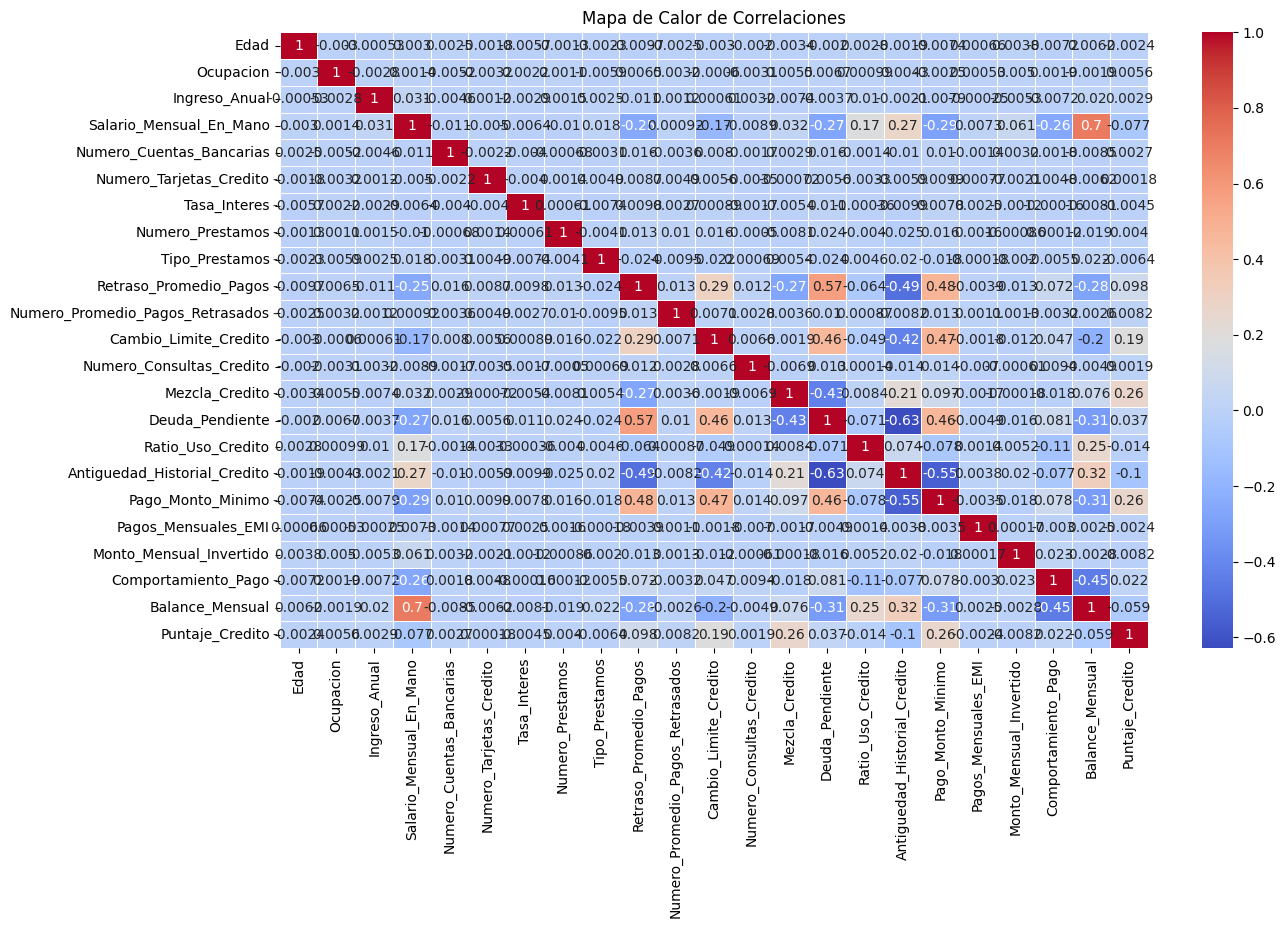

In [53]:

corr_matrix = data_3_multivariables.corr()

plt.figure(figsize=(14, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Mapa de Calor de Correlaciones')
plt.show()


In [54]:
data_4 = data_3_correcto.copy()

### Comenzaremos a imputar nuestros valores faltantes tomando en cuenta la naturaleza de los datos para poder imputarlos de la forma mas precisa posible

In [55]:
ver_nulos(data_4)

,columna,valores nulos
0,Salario_Mensual_En_Mano,15002
1,Tipo_Prestamos,11408
2,Numero_Promedio_Pagos_Retrasados,7002
3,Cambio_Limite_Credito,2091
4,Numero_Consultas_Credito,1965
5,Antiguedad_Historial_Credito,9030
6,Monto_Mensual_Invertido,4479
7,Balance_Mensual,1209


Comenzamos con el salario mensual en mano, el cual tiene una cantidad considerable de valores faltantes por lo cual se busca imputar de la forma mas meticulosa posible, por ello es que utilizaremos k nearest para imputar

In [56]:
caracteristicas_predictoras = [
    'Ingreso_Anual', 
    'Numero_Cuentas_Bancarias', 
    'Numero_Tarjetas_Credito',
    'Tasa_Interes',
    'Numero_Prestamos',
    'Deuda_Pendiente',
    'Ratio_Uso_Credito',
    'Antiguedad_Historial_Credito',
    'Pagos_Mensuales_EMI'
]

data_4_knn = data_4.copy()

X = data_4_knn[caracteristicas_predictoras]

escalador = StandardScaler()
X_escalado = escalador.fit_transform(X)

imputador_knn = KNNImputer(n_neighbors=5)

data_4_knn['Salario_Mensual_En_Mano'] = imputador_knn.fit_transform(
    pd.concat([data_4_knn[['Salario_Mensual_En_Mano']], pd.DataFrame(X_escalado, columns=caracteristicas_predictoras)], axis=1)
)[:, 0]



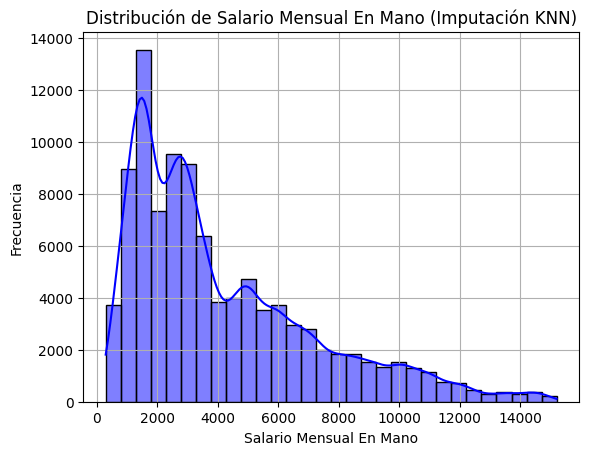

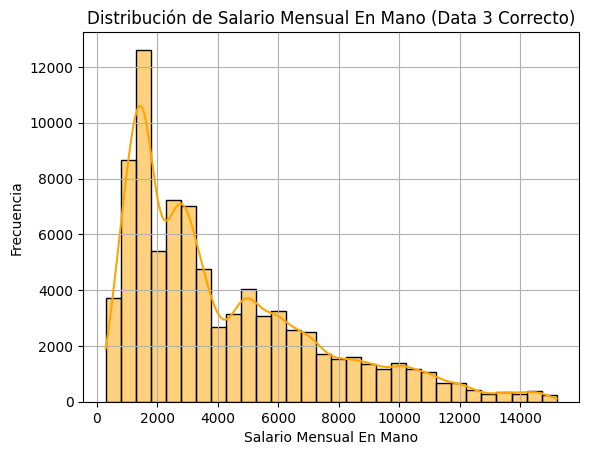

In [57]:

sns.histplot(data_4_knn['Salario_Mensual_En_Mano'], kde=True, color='blue', bins=30)
plt.title('Distribución de Salario Mensual En Mano (Imputación KNN)')
plt.xlabel('Salario Mensual En Mano')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

sns.histplot(data_3_correcto['Salario_Mensual_En_Mano'], kde=True, color='orange', bins=30)
plt.title('Distribución de Salario Mensual En Mano (Data 3 Correcto)')
plt.xlabel('Salario Mensual En Mano')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

Con ello ya tenemos valores representativos para nuestra caracteristica

In [58]:
ver_nulos(data_4_knn)

,columna,valores nulos
0,Tipo_Prestamos,11408
1,Numero_Promedio_Pagos_Retrasados,7002
2,Cambio_Limite_Credito,2091
3,Numero_Consultas_Credito,1965
4,Antiguedad_Historial_Credito,9030
5,Monto_Mensual_Invertido,4479
6,Balance_Mensual,1209


Continuamos con tipo de prestamo, variable que describe cual o cuales son los tipos de prestamos que ha pedido el cliente, dado que se tiene una cantidad alta de categorias, es pertinente imputar los valores nulos como desconocidos o no especificados, como viene originalmente en el data set

In [61]:
data_4_knn['Tipo_Prestamos'].value_counts(ascending=False)

Tipo_Prestamos
Not Specified                                                                                                                         1408
Credit-Builder Loan                                                                                                                   1280
Personal Loan                                                                                                                         1272
Debt Consolidation Loan                                                                                                               1264
Student Loan                                                                                                                          1240
                                                                                                                                      ... 
Not Specified, Mortgage Loan, Auto Loan, and Payday Loan                                                                                 8
Payday Loan,

In [62]:
data_4_knn['Tipo_Prestamos'] = data_4_knn['Tipo_Prestamos'].fillna('Not Specified')

Continuamos con numero promedio de pagos retrasados

In [66]:
data_4_knn['Numero_Promedio_Pagos_Retrasados'].value_counts(ascending=False)

Numero_Promedio_Pagos_Retrasados
19.0      5481
17.0      5412
16.0      5312
10.0      5309
15.0      5237
          ... 
1534.0       1
3739.0       1
3313.0       1
4191.0       1
2047.0       1
Name: count, Length: 711, dtype: int64

Siendo una variable numerica imputaremos con la media

In [68]:
media_pagos_retrasados = data_4_knn['Numero_Promedio_Pagos_Retrasados'].mean()
data_4_knn['Numero_Promedio_Pagos_Retrasados'] = data_4_knn['Numero_Promedio_Pagos_Retrasados'].fillna(media_pagos_retrasados)

Continuamos con el cambio en el limite de credito, esta variable tambien puede ser imputada con la media, debido a que una variacion en el limite de credito es comun y periodica.

Aplic igual para numero de consultas de credito


In [79]:
media_cambio_credito = data_4_knn['Cambio_Limite_Credito'].mean()
data_4_knn['Cambio_Limite_Credito'] = data_4_knn['Cambio_Limite_Credito'].fillna(media_pagos_retrasados)
media_consultas = data_4_knn['Numero_Consultas_Credito'].mean()
data_4_knn['Numero_Consultas_Credito'] = data_4_knn['Numero_Consultas_Credito'].fillna(media_consultas)

Para la antiguedad de historial de credito, siendo un valor de carcter temporal es mas complejo que los dos anteriores por lo que utilizaremos la imputacion de knn para ser lo mas precisos posible

In [81]:

caracteristicas_relevantes_tiempo = [
    'Edad',
    'Numero_Cuentas_Bancarias', 
    'Numero_Tarjetas_Credito', 
    'Deuda_Pendiente', 
    'Puntaje_Credito', 
    'Comportamiento_Pago'
]
data_knn_2 = data_4_knn[caracteristicas_relevantes_tiempo + ['Antiguedad_Historial_Credito']].copy()
data_knn_2['Comportamiento_Pago'] = data_knn_2['Comportamiento_Pago'].astype('category').cat.codes
data_knn_2['Puntaje_Credito'] = data_knn_2['Puntaje_Credito'].astype('category').cat.codes
escalador = StandardScaler()
data_escalada = escalador.fit_transform(data_knn_2)
imputador_knn = KNNImputer(n_neighbors=5)
data_imputada = imputador_knn.fit_transform(data_escalada)
data_imputada = pd.DataFrame(data_imputada, columns=data_knn_2.columns)
data_imputada_desescalada = escalador.inverse_transform(data_imputada)
data_imputada_desescalada = pd.DataFrame(data_imputada_desescalada, columns=data_knn_2.columns)
data_4_knn['Antiguedad_Historial_Credito'] = data_imputada_desescalada['Antiguedad_Historial_Credito']


0    265.0
1    249.4
2    267.0
3    268.0
4    269.0
Name: Antiguedad_Historial_Credito, dtype: float64


In [ ]:
caracteristicas_monto_invertido = [
    'Ingreso_Anual', 
    'Numero_Tarjetas_Credito',
    'Deuda_Pendiente',
    'Ratio_Uso_Credito',
    'Numero_Prestamos',
    'Antiguedad_Historial_Credito',
    'Edad'
]

data_monto_invertido_imputacion = data_4_knn.dropna(subset=caracteristicas_monto_invertido)

X_monto_invertido = data_monto_invertido_imputacion[caracteristicas_monto_invertido]

y_monto_invertido = data_4_knn[['Monto_Mensual_Invertido']]

escalador_monto_invertido = StandardScaler()
X_monto_invertido_escalado = escalador_monto_invertido.fit_transform(X_monto_invertido)

y_monto_invertido_escalado = escalador_monto_invertido.fit_transform(y_monto_invertido)

data_monto_invertido_completa = pd.DataFrame(X_monto_invertido_escalado, columns=caracteristicas_monto_invertido)
data_monto_invertido_completa['Monto_Mensual_Invertido'] = y_monto_invertido_escalado

imputador_knn_monto_invertido = KNNImputer(n_neighbors=5)
data_monto_invertido_imputada = imputador_knn_monto_invertido.fit_transform(data_monto_invertido_completa)

data_monto_invertido_desescalada = escalador_monto_invertido.inverse_transform(data_monto_invertido_imputada)

data_4_knn['Monto_Mensual_Invertido'].iloc[data_4_knn['Monto_Mensual_Invertido'].isnull()] = data_monto_invertido_desescalada[:, -1][data_4_knn['Monto_Mensual_Invertido'].isnull()]


Finalmente nos queda balance_mensual, cuyos valores nulos son de aproximadamennte el 1% de nuestro data set, razon por la cual vamos a eliminar estas filas y continuar con el analisis

In [86]:
data_4_knn = data_4_knn.dropna(subset=['Balance_Mensual'])

In [88]:
data_5 = data_4_knn.copy()

In [89]:
data_5.info()

<class 'pandas.core.frame.DataFrame'>
Index: 98791 entries, 0 to 99999
Data columns (total 23 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Edad                              98791 non-null  int64  
 1   Ocupacion                         98791 non-null  object 
 2   Ingreso_Anual                     98791 non-null  float64
 3   Salario_Mensual_En_Mano           98791 non-null  float64
 4   Numero_Cuentas_Bancarias          98791 non-null  int64  
 5   Numero_Tarjetas_Credito           98791 non-null  int64  
 6   Tasa_Interes                      98791 non-null  int64  
 7   Numero_Prestamos                  98791 non-null  int64  
 8   Tipo_Prestamos                    98791 non-null  object 
 9   Retraso_Promedio_Pagos            98791 non-null  int64  
 10  Numero_Promedio_Pagos_Retrasados  98791 non-null  float64
 11  Cambio_Limite_Credito             98791 non-null  float64
 12  Numero_Co